# Knowledge Graph

## Let's parse HTML, make Knowledge Graph triple data and plot it.

In [47]:
import spacy
from spacy.lang.en import English
import networkx as nx
import requests
from bs4 import BeautifulSoup
import re

from spacy.matcher import Matcher 
from spacy.tokens import Span
from spacy import displacy
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Method 1

In [18]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
#         printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

#     print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()


In [3]:
headers = {'user-agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.122 Safari/537.36"}
url = 'https://en.wikipedia.org/wiki/London'
page = requests.get(url, headers = headers)
page

<Response [200]>

In [4]:
soup = BeautifulSoup(page.text, 'lxml') #using lxml parser. You can use Python’s html.parser.

In [14]:
paragraphs = []
for i, item in enumerate(soup.find_all("p")):
    paragraphs.append(item.text)

In [70]:
# text = ''.join(paragraphs)
text = paragraphs[1]
text = re.sub("[\(\[].*?[\)\]]", "", text)
text = text.rstrip("\n")

In [75]:
text

"London is the capital and largest city of England and the United Kingdom. The city stands on the River Thames in the south-east of England, at the head of its 50-mile  estuary leading to the North Sea, London has been a major settlement for two millennia. Londinium was founded by the Romans. The City of London, London's ancient core and financial centre − an area of just 1.12 square miles  and colloquially known as the Square Mile − retains boundaries that closely follow its medieval limits. The adjacent City of Westminster is an Inner London borough and has for centuries been the location of much of the national government. Thirty one additional boroughs north and south of the river also comprise modern London. London is governed by the mayor of London and the London Assembly."

In [109]:
text = "London is the capital and largest city of England and the United Kingdom. Standing on the River " \
           "Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to " \
           "the North Sea, London has been a major settlement for two millennia. " \
           "Londinium was founded by the Romans. The City of London, " \
           "London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as " \
           "the Square Mile − retains boundaries that follow closely its medieval limits." \
           "The City of Westminster is also an Inner London borough holding city status. " \
           "Greater London is governed by the Mayor of London and the London Assembly." \
           "London is located in the southeast of England." \
           "Westminster is located in London." \
           "London is the biggest city in Britain. London has a population of 7,172,036."

In [110]:
for token in nlp_model(text):
    print(token)

London
is
the
capital
and
largest
city
of
England
and
the
United
Kingdom
.
Standing
on
the
River
Thames
in
the
south
-
east
of
England
,
at
the
head
of
its
50-mile
(
80
km
)
estuary
leading
to
the
North
Sea
,
London
has
been
a
major
settlement
for
two
millennia
.
Londinium
was
founded
by
the
Romans
.
The
City
of
London
,
London
's
ancient
core
−
an
area
of
just
1.12
square
miles
(
2.9
km2
)
and
colloquially
known
as
the
Square
Mile
−
retains
boundaries
that
follow
closely
its
medieval
limits
.
The
City
of
Westminster
is
also
an
Inner
London
borough
holding
city
status
.
Greater
London
is
governed
by
the
Mayor
of
London
and
the
London
Assembly
.
London
is
located
in
the
southeast
of
England
.
Westminster
is
located
in
London
.
London
is
the
biggest
city
in
Britain
.
London
has
a
population
of
7,172,036
.


In [111]:
if __name__ == "__main__":
    sentences = getSentences(text)
    nlp_model = spacy.load('en_core_web_sm')

    triples = []
    for sentence in sentences:
        triples.append(processSentence(sentence))

In [112]:
triples

[('London', 'be capital large', 'England'),
 ('London',
  'be major settlement',
  'Thames east England head estuary Sea millennia'),
 ('Londinium', 'found by', 'Romans'),
 ('City that',
  'ancient square retain medieval',
  'London miles − boundaries limits'),
 ('City', 'be borough', 'Westminster status'),
 ('London', 'govern by', 'Mayor London'),
 ('London', 'locate', 'southeast England'),
 ('Westminster', 'locate', 'London'),
 ('London', 'be big city', 'Britain'),
 ('London', 'have', 'population 7,172,036')]

- For Method 1, I draw an edge as a blob.

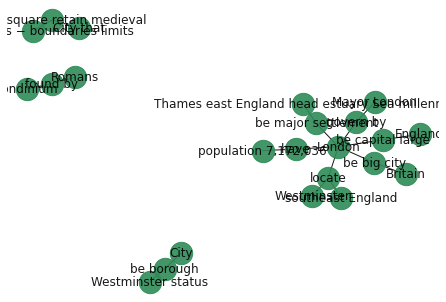

In [113]:
printGraph(triples)

### Method 2

In [85]:
nlp = spacy.load('en_core_web_sm')
def get_entities(sent):
  ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

  #############################################################
  
    for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
          # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                      prefix = prv_tok_text + " "+ tok.text

              # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                      modifier = prv_tok_text + " "+ tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text

          ## chunk 5  
          # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
      #############################################################

    return [ent1.strip(), ent2.strip()]


def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [93]:
text = ''.join(paragraphs)

sentences = getSentences(text)

entity_pairs = []
for sent in sentences:
    entity_pairs.append(get_entities(sent))

relations = []
for sent in sentences:
    relations.append(get_relation(sent))

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [119]:
kg_df.tail()

,source,target,edge
5,Greater London London,London,governed by
6,London,England,located in
7,Westminster,London,located in
8,London,biggest Britain,is
9,London,"7,172,036",has


In [120]:
kg_df['edge'].value_counts()[:10]

is             3
located in     2
retains        1
been           1
has            1
governed by    1
founded by     1
Name: edge, dtype: int64

In [126]:
import numpy as np

In [128]:
condition = np.array([True]*len(kg_df))
condition &= kg_df['source']=='London'

- For Method 2, I do not draw an edge as a blob and make arrows directional.

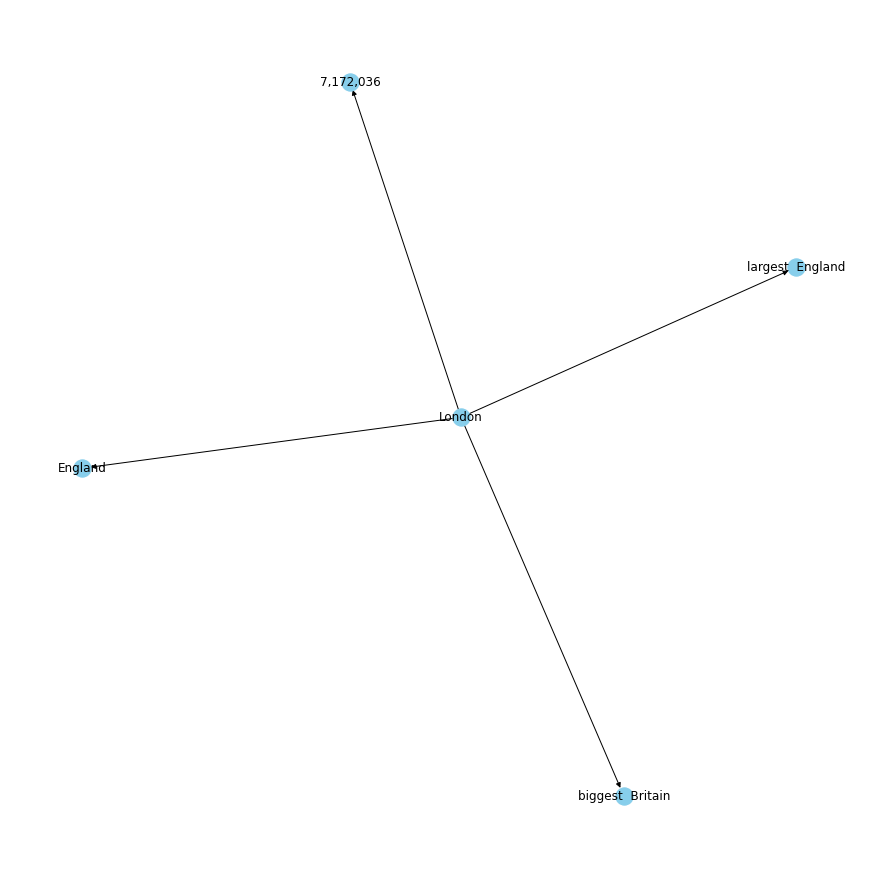

In [130]:
G=nx.from_pandas_edgelist(kg_df[condition], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

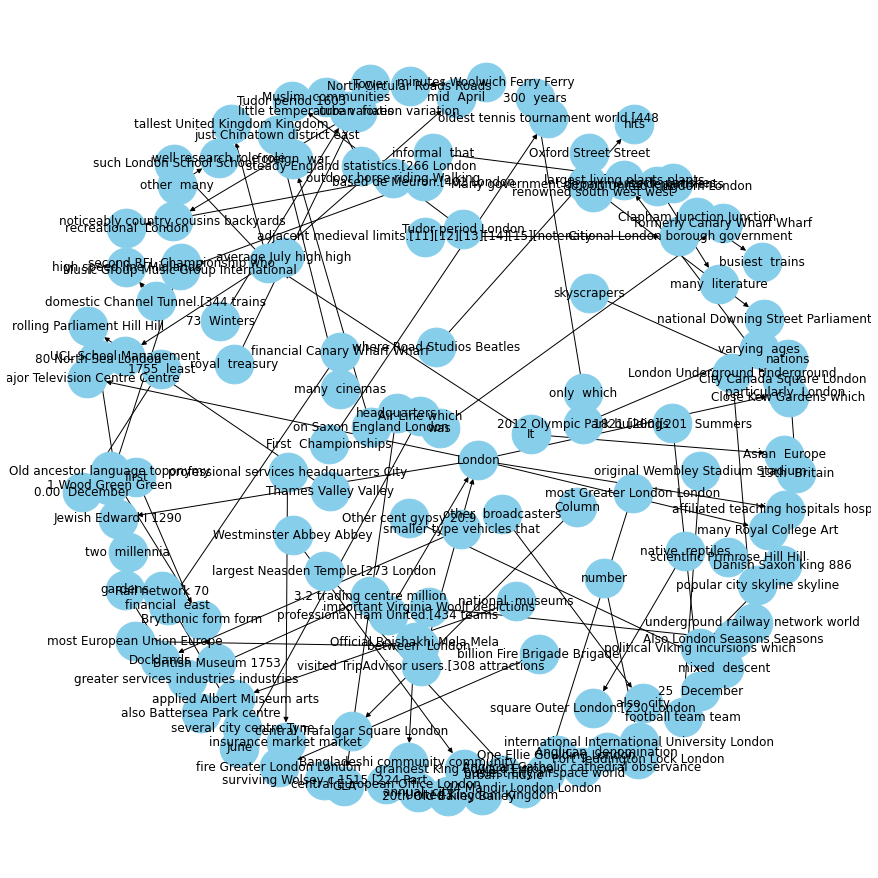

In [107]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge'].isin(["is","was","are","were","been"])], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

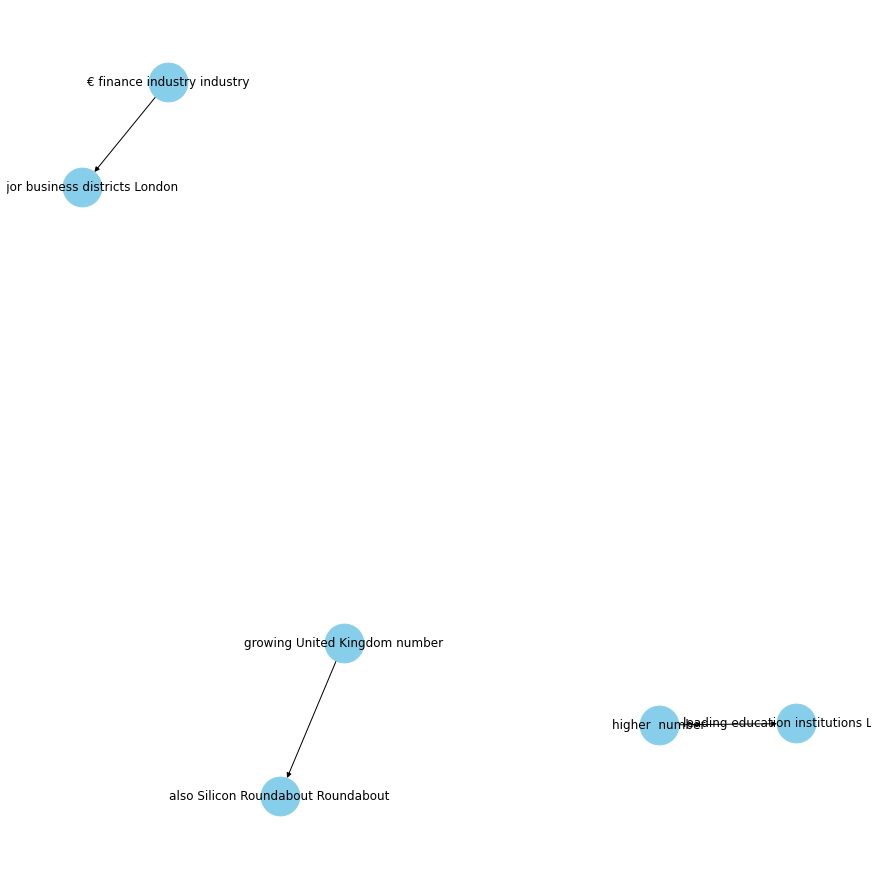

In [108]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=='based in'], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()